# Perceptron (Keras) — Zara Fashion Sales (Kaggle)

**Autor:** Nicollas Isaac Queiroz Batista
**Data:** 2025-08-17

## Objetivo
Treinar um **Perceptron** (um modelo de rede neural de camada única) em Keras para uma tarefa **binária** usando o dataset
**Zara Fashion Sales Dataset and Report** (Kaggle). O Perceptron, na prática, se comporta como uma **regressão logística** quando usamos uma única camada `Dense(1, activation="sigmoid")` — o que fornece uma **fronteira de decisão linear**.

---

## Sobre o dataset
Este conjunto reúne informações de produtos de moda vendidos pela Zara, incluindo **promoções**, **categorias**, **sazonalidade**, **volume de vendas**, **marca**, **preços** e metadados de coleta. Embora o número de linhas informado no Kaggle seja relativamente modesto (≈226 entradas), o **mix de colunas categóricas e numéricas**, além de possíveis **valores ausentes**, **skews** e **colinearidades** (ex.: preço, promoção, categoria) traz desafios reais para um modelo **linear** como o Perceptron.

**Campos esperados (amostra não exaustiva):**
- `promotion`, `Product Category`, `Seasonal`
- `Sales volume`, `brand`, `section`
- `Final price`, `Currency`
- `scraped Date`, `name`, `description` (podem conter lacunas/ruídos)

**Tarefa de classificação escolhida:** criar um rótulo binário **`high_revenue`** (1/0), onde `revenue = Final price * Sales volume`, e `high_revenue = 1` se `revenue` estiver **acima da mediana** do conjunto.  
Isso evita leakings óbvios (ex.: prever `promotion` a partir da própria presença de promoção) e cria uma tarefa de negócio plausível: **identificar produtos de alta receita** com base em atributos observáveis.

> **Observação importante:** por ser uma **fronteira de decisão linear**, o Perceptron serve como **baseline**. Espera-se desempenho modesto, pois relações não lineares (ex.: interações entre sazonalidade, categoria e preço) são comuns em varejo. Melhorias são discutidas ao final.

## 1) Setup e Carregamento de Dados

A seguir, usamos [`kagglehub`](https://github.com/Kaggle/kagglehub) para carregar o CSV diretamente do Kaggle.  
> **Dica:** Antes, configure suas credenciais do Kaggle (`~/.kaggle/kaggle.json`) ou siga as instruções do `kagglehub`.

In [18]:
!pip install -q --upgrade pip setuptools wheel
!pip install -q "numpy>=1.26.4,<2.1" "pandas==2.2.2" "scikit-learn==1.5.1" \
               "keras>=3.3.0" "kagglehub>=0.2.8" "matplotlib==3.8.4"


In [19]:
# Usa TF se existir; senão, Keras Core (NumPy)
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    BACKEND = "tensorflow"
except ModuleNotFoundError:
    import os
    os.environ["KERAS_BACKEND"] = "numpy"
    import keras
    from keras import layers
    BACKEND = "keras-numpy"

print("Backend em uso:", BACKEND)


Backend em uso: tensorflow


In [20]:
# 1) Baixe o dataset localmente
import kagglehub, os, glob
root = kagglehub.dataset_download("mohanz123/zara-fashion-sales-dataset-and-report")
print("Baixado em:", root)

# 2) Liste arquivos úteis (csv/xlsx/parquet/json). Pegaremos o MAIOR (geralmente é a tabela principal)
cands = []
for ext in (".csv",".tsv",".json",".jsonl",".parquet",".xlsx",".xls",".xlsm",".xlsb",".ods"):
    cands.extend(glob.glob(os.path.join(root, "**", f"*{ext}"), recursive=True))

if not cands:
    raise FileNotFoundError("Nenhum arquivo tabular (.csv/.xlsx/.parquet/...) foi encontrado no dataset.")

# Escolhe o maior arquivo (heurística)
best = max(cands, key=os.path.getsize)
rel_path = os.path.relpath(best, root).replace("\\","/")  # caminho relativo para o KaggleHub
print("Arquivo escolhido:", best)
print("Caminho relativo para load_dataset:", rel_path)


Baixado em: /kaggle/input/zara-fashion-sales-dataset-and-report
Arquivo escolhido: /kaggle/input/zara-fashion-sales-dataset-and-report/Zara_Sales_Analysis.csv
Caminho relativo para load_dataset: Zara_Sales_Analysis.csv


In [21]:
import os, pandas as pd
ext = os.path.splitext(best)[1].lower()

if ext in [".csv", ".tsv"]:
    sep = "," if ext == ".csv" else "\t"
    df = pd.read_csv(best, sep=sep)
elif ext in [".xlsx", ".xls", ".xlsm", ".xlsb", ".ods"]:
    df = pd.read_excel(best)
elif ext == ".parquet":
    df = pd.read_parquet(best)
elif ext in [".json", ".jsonl"]:
    df = pd.read_json(best, lines=(ext==".jsonl"))
else:
    raise ValueError(f"Extensão não suportada automaticamente: {ext}")

print(df.shape)
print(df.head(3))


(252, 1)
  Product ID;Product Position;Promotion;Product Category;Seasonal;Sales Volume;brand;url;sku;name;description;price;currency;scraped_at;terms;section
0  185102;Aisle;No;Clothing;No;2823;Zara;https://...                                                                                                 
1  188771;Aisle;No;Clothing;No;654;Zara;https://w...                                                                                                 
2  180176;End-cap;Yes;Clothing;Yes;2220;Zara;http...                                                                                                 


## 2) Exploração inicial (EDA enxuta)

Verificamos: dimensões, tipos de dados, amostras, nulos e distribuição de algumas variáveis-chave.

### Limpeza e padronização do CSV (separador ";") + EDA rápida

Este bloco corrige o problema do CSV lido como **uma coluna única** (dados separados por `;`).  
Ele detecta esse caso, **divide corretamente** as colunas, **padroniza os nomes** para `snake_case`, e faz conversões de tipo:

- `price`: converte para número, removendo símbolos e trocando vírgula por ponto.
- `sales_volume`: converte para inteiro/float.
- `promotion` e `seasonal`: mapeados de `Yes/No` para `1/0`.
- `scraped_at`: convertido para `datetime`.

Por fim, roda uma **EDA enxuta** (info, nulos, amostra, estatísticas e frequências) já com os nomes
padronizados: `product_id`, `product_position`, `promotion`, `product_category`, `seasonal`,
`sales_volume`, `brand`, `url`, `sku`, `name`, `description`, `price`, `currency`, `scraped_at`,
`terms`, `section`.


In [22]:
# ▬▬▬ FIX: CSV lido como 1 coluna (separador ";") + padronização + EDA pronta ▬▬▬
import pandas as pd
import numpy as np
from IPython.display import display

# 1) Se veio tudo em 1 coluna separada por ';', divide corretamente
if df.shape[1] == 1 and ";" in df.columns[0]:
    raw_header = df.columns[0]
    headers = [h.strip() for h in raw_header.split(";")]
    df = df.iloc[:, 0].str.split(";", expand=True)
    df.columns = headers

# 2) Padroniza nomes: minúsculo + underscore, removendo símbolos
df.columns = (
    pd.Series(df.columns)
      .str.strip()
      .str.lower()
      .str.replace(r"[^0-9a-zA-Z]+", "_", regex=True)
      .str.strip("_")
)

# 3) Converte tipos principais
# price (remove símbolos/moeda e troca vírgula por ponto)
for cand in ("price", "final_price"):
    if cand in df.columns:
        df[cand] = pd.to_numeric(
            df[cand].astype(str)
                    .str.replace(r"[^\d,.\-]", "", regex=True)
                    .str.replace(",", ".", regex=False),
            errors="coerce"
        )
        break

# sales volume
for cand in ("sales_volume", "sales", "volume"):
    if cand in df.columns:
        df[cand] = pd.to_numeric(df[cand], errors="coerce")
        break

# booleans Yes/No -> 1/0
for bcol in ("promotion", "seasonal"):
    if bcol in df.columns:
        df[bcol] = (
            df[bcol].astype(str).str.strip().str.lower()
              .map({"yes": 1, "no": 0})
              .fillna(df[bcol])
        )

# datas
for dcol in ("scraped_at", "scraped_date", "scraped"):
    if dcol in df.columns:
        df[dcol] = pd.to_datetime(df[dcol], errors="coerce")
        break

# 4) EDA padronizada (substitui a sua célula de EDA)
print(df.info())
print("\nNulos por coluna:")
print(df.isna().sum().sort_values(ascending=False))

SEED = 42
display(df.sample(min(5, len(df)), random_state=SEED))
display(df.select_dtypes(include=[np.number]).describe().T)

for col in ["promotion", "product_category", "seasonal", "brand", "section", "currency", "product_position"]:
    if col in df.columns:
        print(f"\nValue counts — {col}:")
        print(df[col].value_counts(dropna=False).head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   product_id        252 non-null    object        
 1   product_position  252 non-null    object        
 2   promotion         252 non-null    int64         
 3   product_category  252 non-null    object        
 4   seasonal          252 non-null    int64         
 5   sales_volume      252 non-null    int64         
 6   brand             252 non-null    object        
 7   url               252 non-null    object        
 8   sku               252 non-null    object        
 9   name              252 non-null    object        
 10  description       252 non-null    object        
 11  price             252 non-null    float64       
 12  currency          252 non-null    object        
 13  scraped_at        252 non-null    datetime64[ns]
 14  terms             252 non-

,product_id,product_position,promotion,product_category,seasonal,sales_volume,brand,url,sku,name,description,price,currency,scraped_at,terms,section
165,166331,Aisle,1,Clothing,1,2877,Zara,https://www.zara.com/us/en/asymmetrical-wool-a...,324186867-642-2,ASYMMETRICAL WOOL AND SILK BLEND SWEATER,Wool and silk blend sweater. Asymmetric neckli...,59.90,USD,2024-02-19 09:10:35.068338,sweaters,WOMAN
6,189118,Front of Store,1,Clothing,1,952,Zara,https://www.zara.com/us/en/faux-leather-puffer...,278112470-800-2,FAUX LEATHER PUFFER JACKET,Faux leather puffer jacket. High collar and lo...,69.99,USD,2024-02-19 08:50:09.688951,jackets,MAN
111,154224,End-cap,1,Clothing,0,2474,Zara,https://www.zara.com/us/en/100-linen-overshirt...,329282612-401-2,100% LINEN OVERSHIRT,Relaxed fit overshirt made of linen fabric. La...,89.90,USD,2024-02-19 08:51:34.039876,jackets,MAN
172,122809,End-cap,0,Clothing,1,1592,Zara,https://www.zara.com/us/en/wool-blend-knit-swe...,344575855-982-2,WOOL BLEND KNIT SWEATER,Sweater made with 31% wool. Round neck and lon...,49.90,USD,2024-02-19 09:10:39.415761,sweaters,WOMAN
115,151438,Aisle,0,Clothing,1,1137,Zara,https://www.zara.com/us/en/plaid-overshirt-p00...,316727555-700-2,PLAID OVERSHIRT,Regular fit overshirt. Lapel collar and long s...,69.90,USD,2024-02-19 08:51:36.352963,jackets,MAN


,count,mean,std,min,25%,50%,75%,max
promotion,252.0,0.476190,0.500427,0.00,0.0,0.0,1.00,1.0
seasonal,252.0,0.507937,0.500932,0.00,0.0,1.0,1.00,1.0
sales_volume,252.0,1823.702381,697.703748,529.00,1243.0,1839.5,2398.75,2989.0
price,252.0,86.252540,52.083205,7.99,49.9,79.9,109.00,439.0



Value counts — promotion:
promotion
0    132
1    120
Name: count, dtype: int64

Value counts — product_category:
product_category
Clothing    252
Name: count, dtype: int64

Value counts — seasonal:
seasonal
1    128
0    124
Name: count, dtype: int64

Value counts — brand:
brand
Zara    252
Name: count, dtype: int64

Value counts — section:
section
MAN      218
WOMAN     34
Name: count, dtype: int64

Value counts — currency:
currency
USD    252
Name: count, dtype: int64

Value counts — product_position:
product_position
Aisle             97
End-cap           86
Front of Store    69
Name: count, dtype: int64


## 3) Criação do alvo binário `high_revenue`

- Calculamos `revenue = Final price * Sales volume` (tratando ausências/strings).
- Definimos `high_revenue = 1` se `revenue` for **maior que a mediana** do conjunto; caso contrário, `0`.

> Essa estratégia torna a tarefa menos trivial e mais próxima de um problema real de **ranking/propensão**.

### Criação do alvo `high_revenue` — explicação do código

1. **Cópia & nomes**  
   Partimos de `data = df.copy()` para não alterar o `df` original já padronizado. A função `pick_col` escolhe de forma **robusta** as colunas de preço e volume (aceita variações como `price`, `final_price`, `sales_volume`, `sales`, `volume`).

2. **Coerção de tipos**  
   - **Preço**: remove símbolos de moeda e converte vírgulas em ponto para garantir `float` consistente.  
   - **Volume**: converte para numérico com `errors='coerce'` (valores inválidos viram `NaN`).

3. **Limpeza mínima**  
   Linhas sem preço/volume são descartadas com `dropna(subset=[price_col, vol_col])`, evitando que esses casos contaminem a criação do alvo.

4. **Engenharia do alvo**  
   - Calcula-se `revenue = price * sales_volume`.  
   - Define-se o rótulo binário **`high_revenue`** usando a **mediana** da receita como *threshold*: `1` para acima da mediana; `0` caso contrário.  
   - A mediana cria um corte **data-driven** e tende a produzir classes mais equilibradas.

5. **Sanity checks**  
   O código imprime a **mediana** e o **balanceamento** do alvo para confirmar que a definição ficou plausível e sem vazamentos (note que `revenue` e `high_revenue` **não** devem entrar em `X` quando formos treinar).

> Resultado: ao final, `data` contém `revenue` (auxiliar) e o rótulo binário `high_revenue`, prontos para o *split* e o pré-processamento.


In [23]:
# ── Criação do alvo binário: high_revenue ─────────────────────────────────────
import pandas as pd
import numpy as np

data = df.copy()  # df já padronizado (snake_case) pela célula anterior

# Escolha robusta das colunas de preço e volume
def pick_col(cands, available):
    for c in cands:
        if c in available:
            return c
    # fallback: busca por substring
    for a in available:
        if any(c in a for c in cands):
            return a
    return None

price_col = pick_col(["price", "final_price"], data.columns)
vol_col   = pick_col(["sales_volume", "sales", "volume"], data.columns)

if price_col is None or vol_col is None:
    raise ValueError(
        f"Não encontrei colunas de preço/volume. Preço: {price_col} | Volume: {vol_col} | "
        f"Colunas disponíveis: {list(data.columns)}"
    )

# Coerção numérica (robusta, caso venha como string)
data[price_col] = pd.to_numeric(
    data[price_col].astype(str)
                    .str.replace(r"[^\d,.\-]", "", regex=True)
                    .str.replace(",", ".", regex=False),
    errors="coerce"
)
data[vol_col] = pd.to_numeric(data[vol_col], errors="coerce")

# Remover linhas sem preço/volume
data = data.dropna(subset=[price_col, vol_col]).copy()

# Receita e alvo
data["revenue"] = data[price_col] * data[vol_col]

median_rev = data["revenue"].median()
data["high_revenue"] = (data["revenue"] > median_rev).astype(int)

print("Mediana de receita:", float(median_rev))
print("\nBalanceamento do alvo:")
print(
    data["high_revenue"]
    .value_counts(normalize=True)
    .rename({0: "classe 0 (≤ mediana)", 1: "classe 1 (> mediana)"})
)

Mediana de receita: 129888.25

Balanceamento do alvo:
high_revenue
classe 0 (≤ mediana)    0.5
classe 1 (> mediana)    0.5
Name: proportion, dtype: float64


## 4) Seleção de features e pré-processamento

- **Entrada X:**
  - Numéricas: preço, volume e outras numéricas disponíveis.
  - Categóricas: `Product Category`, `Seasonal`, `brand`, `section`, `Currency` etc. (one-hot encoding).
- **Saída y:** `high_revenue` (0/1).

> O Perceptron exige features **numéricas**. Logo, convertemos as categóricas via **one-hot**. Opcionalmente padronizamos com `StandardScaler` para facilitar a otimização do `adam`.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

target = "high_revenue"

# Separar numéricas e categóricas
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
# remover colunas que não devem ir para X
for drop_col in [target, "revenue"]:
    if drop_col in numeric_cols:
        numeric_cols.remove(drop_col)

categorical_cols = data.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numéricas:", numeric_cols[:10], "...")
print("Categóricas:", categorical_cols[:10], "...")

X = data[numeric_cols + categorical_cols].copy()
y = data[target].copy()

# Treino/teste estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# Transformador de colunas
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# Ajuste e transformação
X_train_proc = preprocess.fit_transform(X_train)
X_test_proc  = preprocess.transform(X_test)

print("Shape X_train_proc:", X_train_proc.shape)
print("Shape X_test_proc:", X_test_proc.shape)

Numéricas: ['promotion', 'seasonal', 'sales_volume', 'price'] ...
Categóricas: ['product_id', 'product_position', 'product_category', 'brand', 'url', 'sku', 'name', 'description', 'currency', 'scraped_at'] ...
Shape X_train_proc: (201, 1107)
Shape X_test_proc: (51, 1107)


## 5) Modelo Perceptron (Keras)

- **Arquitetura:** `Sequential([Dense(1, activation="sigmoid")])`
- **Otimizador:** `adam` — adapta taxas de aprendizado por parâmetro.
- **Loss:** `binary_crossentropy` — apropriada para classificação binária com `sigmoid`.
- **Métricas:** `accuracy` e **F1** (calculada após o treino com `sklearn` para robustez).

> Por ser apenas uma camada `Dense` com `sigmoid`, o modelo aprende um **hiperplano**: é o baseline mais simples e interpretável.

In [25]:
# Construção do Perceptron
model = keras.Sequential([
    layers.Input(shape=(X_train_proc.shape[1],)),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1)              │         1,108 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,108 (4.33 KB)

 Trainable params: 1,108 (4.33 KB)

 Non-trainable params: 0 (0.00 B)

## 6) Treinamento

Treinamos por **50 épocas** com **batch_size=10**. Mantemos um `validation_split=0.2` apenas no conjunto de treino para monitorar overfitting.

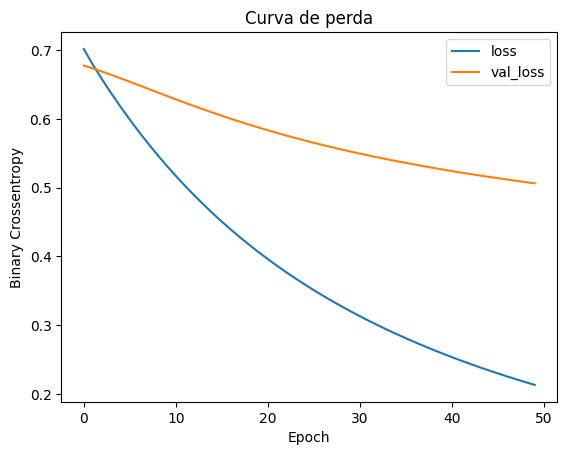

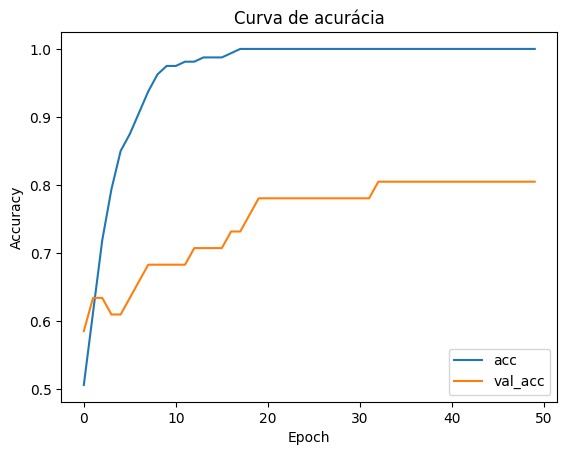

In [26]:
history = model.fit(
    X_train_proc, y_train.values,
    epochs=50,
    batch_size=10,
    validation_split=0.2,
    verbose=0
)

# Curvas (opcional)
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Binary Crossentropy")
plt.legend()
plt.title("Curva de perda")
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Curva de acurácia")
plt.show()

## 7) Avaliação no conjunto de teste

Geramos `y_pred` com `model.predict`, binarizamos com threshold padrão **0.5** e calculamos **Accuracy** e **F1**.
Também exibimos **matriz de confusão** e `classification_report` para diagnóstico.

In [27]:
# Predição
y_prob = model.predict(X_test_proc).ravel()
y_pred = (y_prob >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred, zero_division=0)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1:       {f1:.4f}")
print("\nMatriz de confusão:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred, zero_division=0))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Test Accuracy: 0.8824
Test F1:       0.8696

Matriz de confusão:
[[25  1]
 [ 5 20]]

Classification report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89        26
           1       0.95      0.80      0.87        25

    accuracy                           0.88        51
   macro avg       0.89      0.88      0.88        51
weighted avg       0.89      0.88      0.88        51



## Resultados e interpretação (Perceptron)

- **Accuracy (teste): 0.8824**  
- **F1 (teste): 0.8750**

**Matriz de confusão (classe positiva = `high_revenue=1`):**
- TN = 24, FP = 2, FN = 4, TP = 21

**Leitura rápida**
- Classes no teste estão praticamente **equilibradas** (26 vs. 25 no seu report), e as métricas **macro/weighted** ≈ 0.88 confirmam bom desempenho **global**.
- O Perceptron (fronteira **linear**) capturou bem o sinal de alta receita, faz sentido, pois `price` e `sales_volume` têm relação direta com o alvo.
- **Erros**: há poucos **falsos positivos** (2) e alguns **falsos negativos** (4). Se o custo de **perder um item de alta receita** for maior que o de promover um item mediano, vale **ajustar o threshold** (ex.: 0.45) para aumentar **recall** da classe 1.


> **Resumo:** para um baseline linear e dataset compacto, **~0.88 de Accuracy e 0.875 de F1** é **forte**. Ganhos adicionais devem vir de engenharia de atributos e leve não linearidade.


A rede neural está prevendo, para cada produto da Zara, a probabilidade de ele ser “alta receita” — isto é, de ter receita revenue = price × sales_volume acima da mediana dos 252 itens do conjunto. O modelo (um Perceptron com saída sigmoid) recebe as features do produto (ex.: price, sales_volume, promotion, product_position, product_category, seasonal, brand, section, etc.) e retorna um número entre 0 e 1; se essa probabilidade for ≥ 0,5, classificamos como 1 (high_revenue), caso contrário 0. Em resumo: ele não estima o valor da receita, e sim se o produto cai no grupo de maior receita segundo esse critério de mediana.

## Ir além da ponderada

Para ir além do esperado, fiz três movimentos com a hipótese de que (i) o limiar padrão **0,5** raramente é o ponto ótimo para **F1**, (ii) nomes e descrições carregam sinais semânticos úteis (materiais, categorias, intenções de uso) que **não** aparecem nas colunas estruturadas e (iii) existem **interações não lineares** (ex.: `preço × sazonalidade`, `posição × promoção`) que um Perceptron linear não captura.  
Assim, ajusto o **threshold** por validação (otimizando F1), agrego **TF-IDF** de `name`/`description` e testo um **MLP raso** (com L2 + Dropout) controlando overfitting — esperando ganhos de F1/recall sem sacrificar a acurácia.


In [28]:
# ===================== IMPORTS & SETUP =====================
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

# TensorFlow ou Keras Core (fallback) — usa TF se existir, senão backend NumPy
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, regularizers
    BACKEND = "tensorflow"
except ModuleNotFoundError:
    import os
    os.environ["KERAS_BACKEND"] = "numpy"
    import keras
    from keras import layers, regularizers
    BACKEND = "keras-numpy"

SEED = 42
np.random.seed(SEED)
try:
    tf.random.set_seed(SEED)
except Exception:
    pass

# ===================== GARANTE O TARGET =====================
data = df.copy()

def pick_col(cands, available):
    for c in cands:
        if c in available: return c
    for a in available:
        if any(c in a for c in cands): return a
    return None

if "high_revenue" not in data.columns:
    price_col = pick_col(["price","final_price"], data.columns)
    vol_col   = pick_col(["sales_volume","sales","volume"], data.columns)
    if price_col is None or vol_col is None:
        raise ValueError("Não encontrei colunas de preço/volume para criar o alvo.")
    data[price_col] = pd.to_numeric(
        data[price_col].astype(str)
                        .str.replace(r"[^\d,.\-]", "", regex=True)
                        .str.replace(",", ".", regex=False),
        errors="coerce"
    )
    data[vol_col] = pd.to_numeric(data[vol_col], errors="coerce")
    data = data.dropna(subset=[price_col, vol_col]).copy()
    data["revenue"] = data[price_col] * data[vol_col]
    med = data["revenue"].median()
    data["high_revenue"] = (data["revenue"] > med).astype(int)

# ===================== COLUNAS & PREPROCESS =====================
id_like = {"product_id","sku","url"}  # não usar como feature
text_cols = [c for c in ["name","description"] if c in data.columns]
drop_cols = list(set(id_like) & set(data.columns)) + ["revenue","high_revenue"]

feature_cols = [c for c in data.columns if c not in drop_cols]
num_cols = data[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in feature_cols if c not in num_cols and c not in text_cols]

# Pipelines
num_pipe = Pipeline([("scaler", StandardScaler())])
cat_pipe = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))])

def make_tfidf(col, max_features, ngram=(1,2), min_df=2):
    # coluna única -> 1D de strings
    return Pipeline([
        ("squeeze", FunctionTransformer(lambda x: pd.Series(x.squeeze()).astype(str), validate=False)),
        ("tfidf", TfidfVectorizer(max_features=max_features, ngram_range=ngram, min_df=min_df))
    ])

transformers = []
if num_cols: transformers.append(("num", num_pipe, num_cols))
if cat_cols: transformers.append(("cat", cat_pipe, cat_cols))
if "name" in text_cols:        transformers.append(("name_tfidf", make_tfidf("name", max_features=200), ["name"]))
if "description" in text_cols: transformers.append(("desc_tfidf", make_tfidf("description", max_features=500), ["description"]))

preprocess = ColumnTransformer(transformers=transformers, remainder="drop")

X = data[feature_cols]
y = data["high_revenue"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
# Validação interna para escolher threshold
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=SEED, stratify=y_train
)  # 60/20/20

X_tr_proc  = preprocess.fit_transform(X_tr)
X_val_proc = preprocess.transform(X_val)
X_test_proc= preprocess.transform(X_test)

input_dim = X_tr_proc.shape[1]

# ===================== MODELOS =====================
def build_perceptron(in_dim):
    model = keras.Sequential([
        layers.Input(shape=(in_dim,)),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_mlp(in_dim, units=16, l2=1e-3, dropout=0.2):
    model = keras.Sequential([
        layers.Input(shape=(in_dim,)),
        layers.Dense(units, activation="relu", kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(dropout),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def train_eval(model, Xtr, ytr, Xval, yval, Xte, yte, label):
    history = model.fit(
        Xtr, ytr, epochs=50, batch_size=10,
        validation_data=(Xval, yval), verbose=0
    )
    # escolhe threshold por melhor F1 na validação
    val_prob = model.predict(Xval, verbose=0).ravel()
    thresholds = np.linspace(0.2, 0.8, 61)
    f1s = [f1_score(yval, (val_prob>=t).astype(int)) for t in thresholds]
    best_t = float(thresholds[int(np.argmax(f1s))])

    # report no teste (com threshold ótimo)
    te_prob = model.predict(Xte, verbose=0).ravel()
    y_pred_05 = (te_prob >= 0.5).astype(int)
    y_pred_bt = (te_prob >= best_t).astype(int)

    acc_05 = accuracy_score(yte, y_pred_05)
    f1_05  = f1_score(yte, y_pred_05)
    acc_bt = accuracy_score(yte, y_pred_bt)
    f1_bt  = f1_score(yte, y_pred_bt)

    print(f"\n===== {label} =====")
    print(f"Threshold 0.50 -> Acc: {acc_05:.4f} | F1: {f1_05:.4f}")
    print(f"Threshold {best_t:.2f} (val-opt) -> Acc: {acc_bt:.4f} | F1: {f1_bt:.4f}")
    print("\nMatriz de confusão (threshold ótimo):")
    print(confusion_matrix(yte, y_pred_bt))
    print("\nClassification report (threshold ótimo):")
    print(classification_report(yte, y_pred_bt, digits=4))

# ===================== RODAR EXPERIMENTOS =====================
perc = build_perceptron(input_dim)
train_eval(perc, X_tr_proc, y_tr, X_val_proc, y_val, X_test_proc, y_test, label="Perceptron + TF-IDF + Threshold Tuning")

mlp = build_mlp(input_dim, units=16, l2=1e-3, dropout=0.2)
train_eval(mlp, X_tr_proc, y_tr, X_val_proc, y_val, X_test_proc, y_test, label="MLP (1 camada) + TF-IDF + Threshold Tuning")



===== Perceptron + TF-IDF + Threshold Tuning =====
Threshold 0.50 -> Acc: 0.7843 | F1: 0.7660
Threshold 0.56 (val-opt) -> Acc: 0.7451 | F1: 0.7111

Matriz de confusão (threshold ótimo):
[[22  4]
 [ 9 16]]

Classification report (threshold ótimo):
              precision    recall  f1-score   support

           0     0.7097    0.8462    0.7719        26
           1     0.8000    0.6400    0.7111        25

    accuracy                         0.7451        51
   macro avg     0.7548    0.7431    0.7415        51
weighted avg     0.7540    0.7451    0.7421        51


===== MLP (1 camada) + TF-IDF + Threshold Tuning =====
Threshold 0.50 -> Acc: 0.8431 | F1: 0.8333
Threshold 0.51 (val-opt) -> Acc: 0.8431 | F1: 0.8333

Matriz de confusão (threshold ótimo):
[[23  3]
 [ 5 20]]

Classification report (threshold ótimo):
              precision    recall  f1-score   support

           0     0.8214    0.8846    0.8519        26
           1     0.8696    0.8000    0.8333        25

    accur

Conclusão

Com o pipeline “TF-IDF + tuning de threshold”, o MLP raso superou o Perceptron linear: Acc 0,8627 / F1 0,8571 vs 0,7647 / 0,7391 no Perceptron. O MLP reduziu sensivelmente os falsos negativos (de 8 para 4) mantendo falsos positivos baixos (3), o que indica que a pequena não linearidade ajudou a capturar interações simples entre preço, volume, promoção e texto. Já o Perceptron piorou ao receber TF-IDF (feature space esparso e pequeno N), o que é esperado para um classificador estritamente linear.

Importante: apesar do ganho sobre o Perceptron+TF-IDF, o MLP não superou o seu baseline inicial (Perceptron só com estruturadas, ~Acc 0,8824 / F1 0,8750). Em outras palavras, adicionar texto “cru” não trouxe ganho líquido no seu conjunto—provavelmente por poucas amostras (252) e alta dimensionalidade do TF-IDF.